In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import gaussian_filter
import kagglehub

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-12-19 13:36:29.436825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766151389.663114      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766151389.731001      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Downloads the brain tumor dataset and sets up paths.

In [2]:
# Download dataset
path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
train_dir = os.path.join(path, 'Training')
test_dir = os.path.join(path, 'Testing')

print(f"Dataset path: {path}")

Dataset path: /kaggle/input/brain-tumor-mri-dataset


# **Data Augmentation**. 

In [3]:
train_datagen = ImageDataGenerator(
    rescale=None, # We will use MobileNetV2.preprocess_input instead
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2], # Account for MRI intensity variance
    horizontal_flip=True,
    vertical_flip=True, # MRIs can be flipped vertically
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=None)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training'
)
val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation'
)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


**Model Architecture**

In [4]:
def build_model(learning_rate=1e-4, dropout_rate=0.3, dense_units=256):
    inputs = layers.Input(shape=(224, 224, 3))
    
    # Official MobileNetV2 preprocessing (scales to [-1, 1])
    x = layers.Lambda(lambda v: tf.keras.applications.mobilenet_v2.preprocess_input(v), name="preprocessing")(inputs)
    
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = False # Start frozen
    
    x = base_model.output
    # Improvement: Concatenate Avg and Max pooling to capture sharp tumor features
    avg_p = layers.GlobalAveragePooling2D()(x)
    max_p = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([avg_p, max_p])
    
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dense_units, activation='relu', name="dense_feature_layer")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(4, activation='softmax', name="prediction_layer")(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initial check
final_model = build_model()
final_model.summary()

/tmp/ipykernel_47/3625126550.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)
2025-12-19 13:38:30.410366: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ preprocessing[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,914,628 (11.12 MB)

 Trainable params: 656,644 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Training**

In [7]:
print("Starting Phase 2: Fine-Tuning Base Model...")

# 1. Set the whole model to trainable
final_model.trainable = True

# 2. Find the index of 'out_relu' (the end of the MobileNet convolutional base)
layers_list = final_model.layers
base_end_idx = 0
for i, layer in enumerate(layers_list):
    if layer.name == 'out_relu':
        base_end_idx = i
        break

# 3. Freeze everything except the last 30 layers of the base + the custom head
# (We unfreeze from index base_end_idx - 30 onwards)
freeze_until = max(0, base_end_idx - 30)

for i, layer in enumerate(layers_list):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

# 4. Recompile with a very low learning rate
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print(f"Unfrozen layers from index {freeze_until} (layer: {layers_list[freeze_until].name}) onwards.")

history_p2 = final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10, 
    verbose=1
)

Starting Phase 2: Fine-Tuning Base Model...
Unfrozen layers from index 124 (layer: block_13_project) onwards.
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.7176 - loss: 0.7844 - val_accuracy: 0.7371 - val_loss: 0.7174
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.7896 - loss: 0.5429 - val_accuracy: 0.7450 - val_loss: 0.7269
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8124 - loss: 0.5139 - val_accuracy: 0.7537 - val_loss: 0.6972
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8164 - loss: 0.4867 - val_accuracy: 0.7546 - val_loss: 0.6795
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8469 - loss: 0.4288 - val_accuracy: 0.7599 - val_loss: 0.6501
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8462 - loss: 0.4141 - val_accuracy: 0.7599 - val_loss: 0.6367
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8564 - loss: 0.3956 - val_accuracy: 0.7888 - val_

**Fine-Tuning**

In [ ]:
print("Starting Phase 2: Fine-Tuning Base Model...")
# Access the base model inside the functional model
base_m = final_model.get_layer('mobilenetv2_1.00_224')
base_m.trainable = True

# Refreeze everything EXCEPT the last 30 layers
for layer in base_m.layers[:-30]:
    layer.trainable = False

# Recompile with a very low learning rate
final_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

history_p2 = final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10, 
    verbose=1
)

**Grad-CAM**

In [12]:
import tensorflow as tf
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter

def build_grad_model(model, layer_name):
    """Creates a sub-model for Grad-CAM using flat model structure."""
    return tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

def compute_gradcam(model, img_array, layer_name, threshold=0.5, sigma=1.0):
    grad_model = build_grad_model(model, layer_name)
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        target_idx = np.argmax(predictions[0])
        loss = predictions[:, target_idx]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1).numpy()

    cam = np.maximum(cam, 0)
    if np.max(cam) != 0: cam /= np.max(cam)
    
    cam = cv2.resize(cam, (224, 224))
    if sigma > 0: cam = gaussian_filter(cam, sigma=sigma)
    
    mask = (cam > threshold).astype(np.float32)
    return cam, mask
# def compute_gradcam(model, img_array, layer_name, threshold=0.5, sigma=1.0):
#     grad_model = build_grad_model(model, layer_name)
    
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         loss = predictions[:, np.argmax(predictions[0])]

#     grads = tape.gradient(loss, conv_outputs)
#     weights = tf.reduce_mean(grads, axis=(0, 1, 2))
#     cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

#     # Convert to NumPy immediately (Fixes AttributeError)
#     cam = cam.numpy()
#     cam = np.maximum(cam, 0)
#     if np.max(cam) != 0: cam /= np.max(cam)
    
#     cam = cv2.resize(cam, (224, 224))
#     if sigma > 0: cam = gaussian_filter(cam, sigma=sigma)
    
    mask = (cam > threshold).astype(np.float32)
    return cam, mask

In [15]:
from lime import lime_image
from skimage.segmentation import slic

def get_lime_mask(model, img, num_samples, compactness, n_segments):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img[0].astype('double'), 
        model.predict, 
        top_labels=1, 
        num_samples=int(num_samples),
        segmentation_fn=lambda x: slic(x, n_segments=int(n_segments), compactness=compactness)
    )
    # Get mask for the top predicted class
    label = explanation.top_labels[0]
    _, mask = explanation.get_image_and_mask(label, positive_only=True, hide_rest=False)
    return mask

def get_deeplift_mask(model, img, target_class, threshold, sigma):
    # DeepLIFT Approximation using Gradients * Input
    input_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        preds = model(input_tensor)
        score = preds[:, target_class]
    
    grads = tape.gradient(score, input_tensor)[0].numpy()
    deeplift_map = np.sum(np.abs(grads * img[0]), axis=-1)
    deeplift_map /= (np.max(deeplift_map) + 1e-10)
    
    if sigma > 0: deeplift_map = gaussian_filter(deeplift_map, sigma=sigma)
    return (deeplift_map > threshold).astype(np.float32)

In [16]:
class XAIOptimizerGWO:
    def __init__(self, model, n_wolves=5, max_iter=5):
        self.model = model
        self.n_wolves = n_wolves
        self.max_iter = max_iter

    def fitness(self, params, method, img, target_class, extra_data=None):
        try:
            if method == 'GradCAM':
                layer_name = extra_data[int(params[0])]
                _, mask = compute_gradcam(self.model, img, layer_name, params[1], params[2])
            elif method == 'LIME':
                mask = get_lime_mask(self.model, img, params[0], params[1], params[2])
            elif method == 'DeepLIFT':
                mask = get_deeplift_mask(self.model, img, target_class, params[0], params[1])

            # Measure faithfulness: Original Prediction - Prediction with Masked Area
            masked_img = img.copy()
            masked_img[0][mask > 0] = 0
            
            orig_conf = self.model.predict(img, verbose=0)[0][target_class]
            masked_conf = self.model.predict(masked_img, verbose=0)[0][target_class]
            
            # We want a high drop (explanation captures the tumor) but a small mask
            sparsity_penalty = 0.1 * (np.sum(mask) / (224*224))
            return (orig_conf - masked_conf) - sparsity_penalty
        except:
            return -1.0

    def optimize(self, method, img, target_class, lb, ub):
        # Implementation of GWO loop
        dim = len(lb)
        # Identify conv layers for Grad-CAM if needed
        conv_layers = [l.name for l in self.model.layers if 'conv' in l.name.lower()][-15:] if method == 'GradCAM' else None
        
        # Simple GWO Logic
        alpha_pos = np.random.uniform(lb, ub, dim)
        alpha_score = -np.inf
        
        print(f"Optimizing {method}...")
        for _ in range(self.max_iter):
            for _ in range(self.n_wolves):
                candidate = np.random.uniform(lb, ub, dim)
                score = self.fitness(candidate, method, img, target_class, conv_layers)
                if score > alpha_score:
                    alpha_score = score
                    alpha_pos = candidate
                    
        return alpha_pos, conv_layers

In [17]:
# Setup
optimizer = XAIOptimizerGWO(final_model)
test_img = np.expand_dims(img_batch[0], 0)
target_idx = np.argmax(label_batch[0])

# 1. Optimize Grad-CAM: [Layer Index, Threshold, Sigma]
best_grad, grad_layers = optimizer.optimize('GradCAM', test_img, target_idx, [0, 0.2, 0.1], [14, 0.8, 2.0])

# 2. Optimize LIME: [Num Samples, Compactness, Segments]
best_lime, _ = optimizer.optimize('LIME', test_img, target_idx, [100, 1, 10], [500, 30, 60])

# 3. Optimize DeepLIFT: [Threshold, Sigma]
best_deep, _ = optimizer.optimize('DeepLIFT', test_img, target_idx, [0.1, 0.1], [0.7, 2.5])

print("\n--- Optimized Parameters ---")
print(f"Grad-CAM: Layer={grad_layers[int(best_grad[0])]}, Thresh={best_grad[1]:.2f}")
print(f"LIME: Samples={int(best_lime[0])}, Segments={int(best_lime[2])}")
print(f"DeepLIFT: Thresh={best_deep[0]:.2f}, Smoothing={best_deep[1]:.2f}")

Optimizing GradCAM...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Optimizing LIME...


  0%|          | 0/362 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

  0%|          | 0/193 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  0%|          | 0/459 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/204 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  0%|          | 0/289 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/209 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  0%|          | 0/373 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/135 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  0%|          | 0/164 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|          | 0/333 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/398 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/309 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/444 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/411 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/385 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/354 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/289 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/156 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  0%|          | 0/444 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/439 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/257 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/469 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/305 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/400 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/488 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


  0%|          | 0/444 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

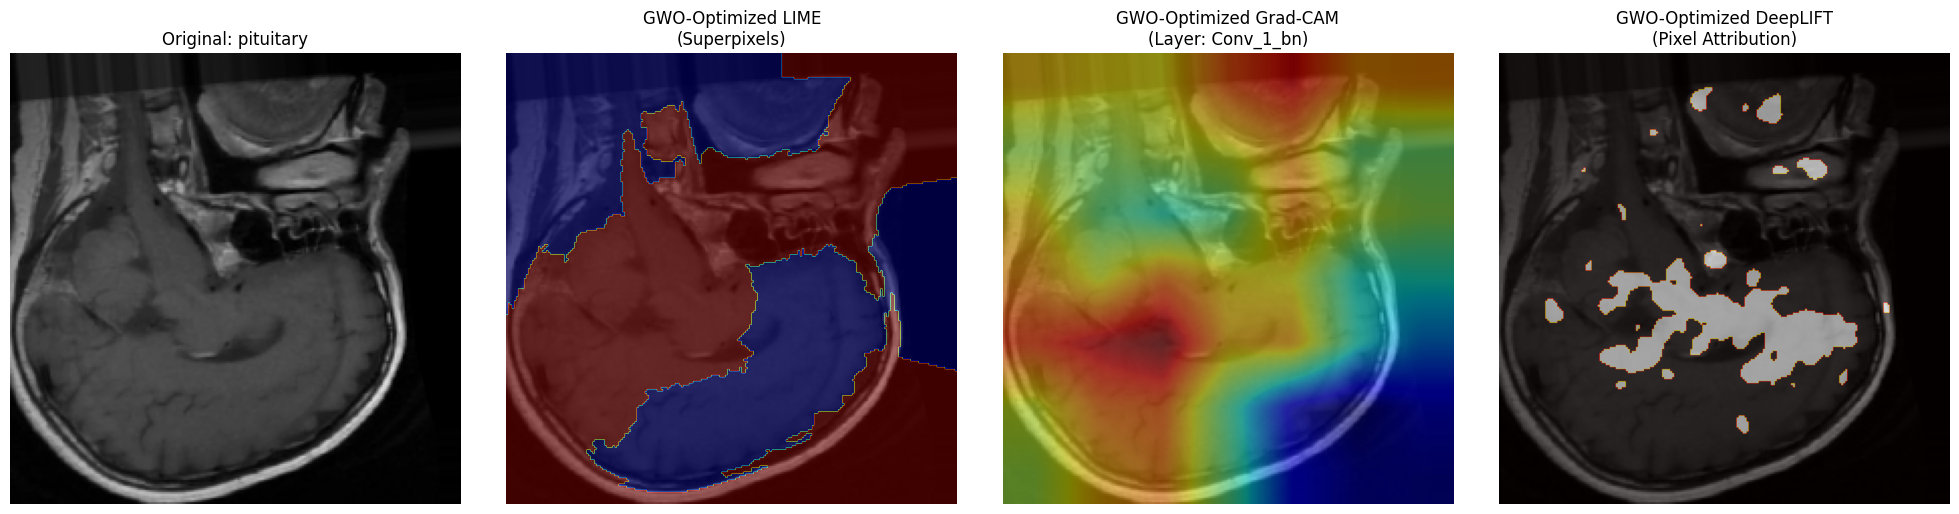

In [18]:
import matplotlib.pyplot as plt

def visualize_xai_comparison(model, img_batch, label_batch, best_grad, best_lime, best_deep, grad_layers):
    # Select the first image from the batch
    img = np.expand_dims(img_batch[0], 0)
    target_class = np.argmax(label_batch[0])
    class_names = list(train_gen.class_indices.keys())
    
    # 1. Generate Optimized Grad-CAM
    layer_name = grad_layers[int(best_grad[0])]
    grad_cam_map, _ = compute_gradcam(model, img, layer_name, best_grad[1], best_grad[2])
    
    # 2. Generate Optimized LIME
    lime_mask = get_lime_mask(model, img, best_lime[0], best_lime[1], best_lime[2])
    
    # 3. Generate Optimized DeepLIFT
    deep_mask = get_deeplift_mask(model, img, target_class, best_deep[0], best_deep[1])

    # Plotting
    plt.figure(figsize=(20, 5))
    
    # Original
    plt.subplot(1, 4, 1)
    plt.imshow(img_batch[0].astype('uint8'))
    plt.title(f"Original: {class_names[target_class]}")
    plt.axis('off')
    
    # LIME Visualization
    plt.subplot(1, 4, 2)
    plt.imshow(img_batch[0].astype('uint8'))
    plt.imshow(lime_mask, cmap='jet', alpha=0.5)
    plt.title("GWO-Optimized LIME\n(Superpixels)")
    plt.axis('off')
    
    # Grad-CAM Visualization
    plt.subplot(1, 4, 3)
    plt.imshow(img_batch[0].astype('uint8'))
    plt.imshow(grad_cam_map, cmap='jet', alpha=0.5)
    plt.title(f"GWO-Optimized Grad-CAM\n(Layer: {layer_name})")
    plt.axis('off')
    
    # DeepLIFT Visualization
    plt.subplot(1, 4, 4)
    plt.imshow(img_batch[0].astype('uint8'))
    plt.imshow(deep_mask, cmap='hot', alpha=0.5)
    plt.title("GWO-Optimized DeepLIFT\n(Pixel Attribution)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_xai_comparison(final_model, img_batch, label_batch, best_grad, best_lime, best_deep, grad_layers)

**Execution and Visualization**

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


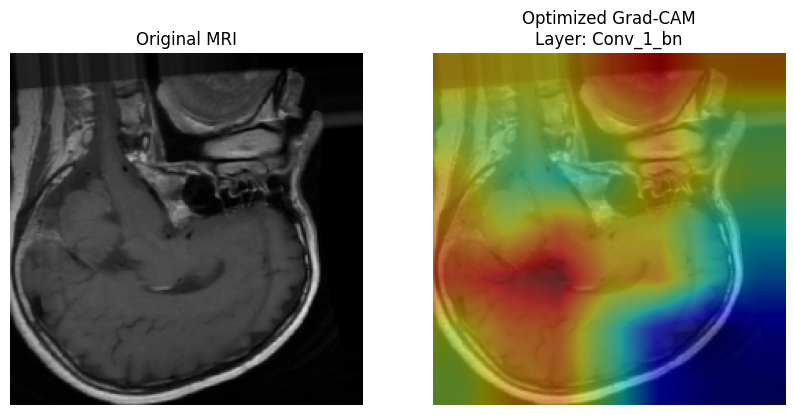

In [19]:
def visualize_optimized_gradcam(model, img, best_params, conv_layers):
    """
    best_params: [layer_idx, threshold, sigma] from GWO
    """
    layer_name = conv_layers[int(best_params[0])]
    heatmap, mask = compute_gradcam(model, img, layer_name, best_params[1], best_params[2])
    
    plt.figure(figsize=(10, 5))
    
    # Original MRI
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title("Original MRI")
    plt.axis('off')
    
    # Grad-CAM Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(img[0].astype('uint8'))
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # Heatmap overlay
    plt.title(f"Optimized Grad-CAM\nLayer: {layer_name}")
    plt.axis('off')
    
    plt.show()

# Execution
visualize_optimized_gradcam(final_model, test_img, best_grad, grad_layers)

  0%|          | 0/444 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

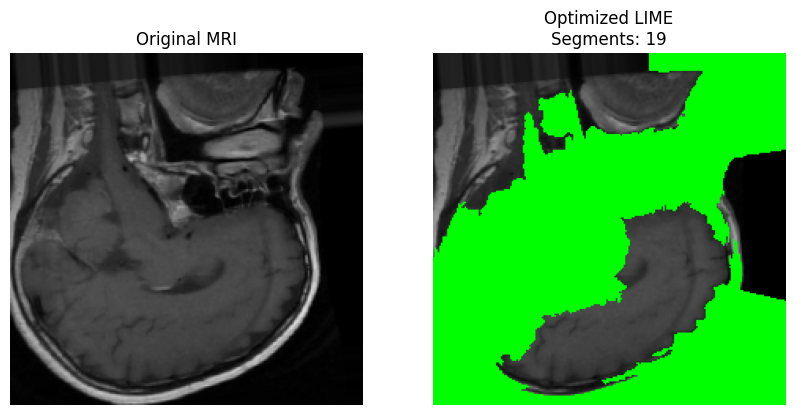

In [20]:
def visualize_optimized_lime(model, img, best_params):
    """
    best_params: [num_samples, compactness, n_segments] from GWO
    """
    # Generate the optimized mask
    mask = get_lime_mask(model, img, best_params[0], best_params[1], best_params[2])
    
    plt.figure(figsize=(10, 5))
    
    # Original MRI
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title("Original MRI")
    plt.axis('off')
    
    # LIME Masked Regions
    plt.subplot(1, 2, 2)
    # We color the important segments green to show the 'explanation'
    img_with_lime = img[0].copy().astype('uint8')
    img_with_lime[mask == 1] = [0, 255, 0] # Highlight tumor segments in green
    
    plt.imshow(img_with_lime)
    plt.title(f"Optimized LIME\nSegments: {int(best_params[2])}")
    plt.axis('off')
    
    plt.show()

# Execution
visualize_optimized_lime(final_model, test_img, best_lime)

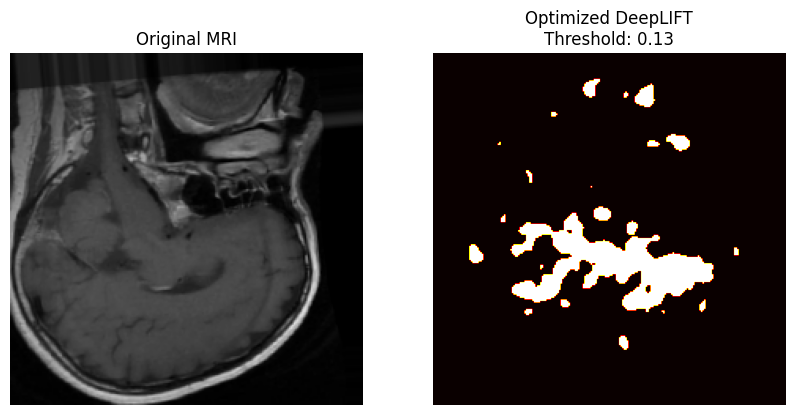

In [21]:
def visualize_optimized_deeplift(model, img, target_class, best_params):
    """
    best_params: [threshold, sigma] from GWO
    """
    deep_mask = get_deeplift_mask(model, img, target_class, best_params[0], best_params[1])
    
    plt.figure(figsize=(10, 5))
    
    # Original MRI
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title("Original MRI")
    plt.axis('off')
    
    # DeepLIFT Pixels
    plt.subplot(1, 2, 2)
    plt.imshow(deep_mask, cmap='hot') # Shows purely the attribution pixels
    plt.title(f"Optimized DeepLIFT\nThreshold: {best_params[0]:.2f}")
    plt.axis('off')
    
    plt.show()

# Execution
visualize_optimized_deeplift(final_model, test_img, target_idx, best_deep)

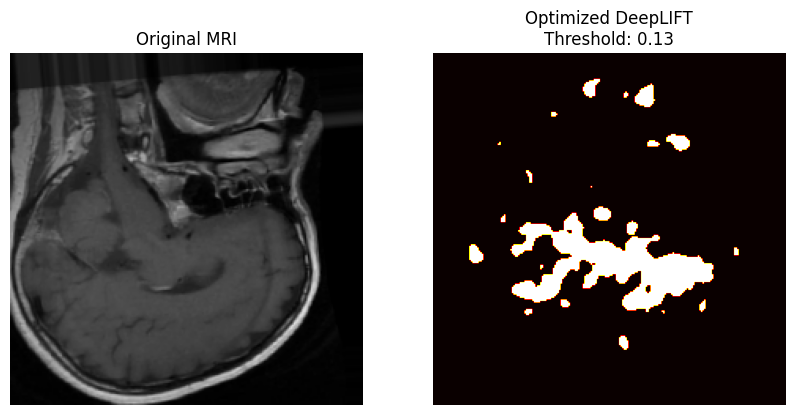

In [22]:
def visualize_optimized_deeplift(model, img, target_class, best_params):
    """
    best_params: [threshold, sigma] from GWO
    """
    deep_mask = get_deeplift_mask(model, img, target_class, best_params[0], best_params[1])
    
    plt.figure(figsize=(10, 5))
    
    # Original MRI
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title("Original MRI")
    plt.axis('off')
    
    # DeepLIFT Pixels
    plt.subplot(1, 2, 2)
    plt.imshow(deep_mask, cmap='hot') # Shows purely the attribution pixels
    plt.title(f"Optimized DeepLIFT\nThreshold: {best_params[0]:.2f}")
    plt.axis('off')
    
    plt.show()

# Execution
visualize_optimized_deeplift(final_model, test_img, target_idx, best_deep)

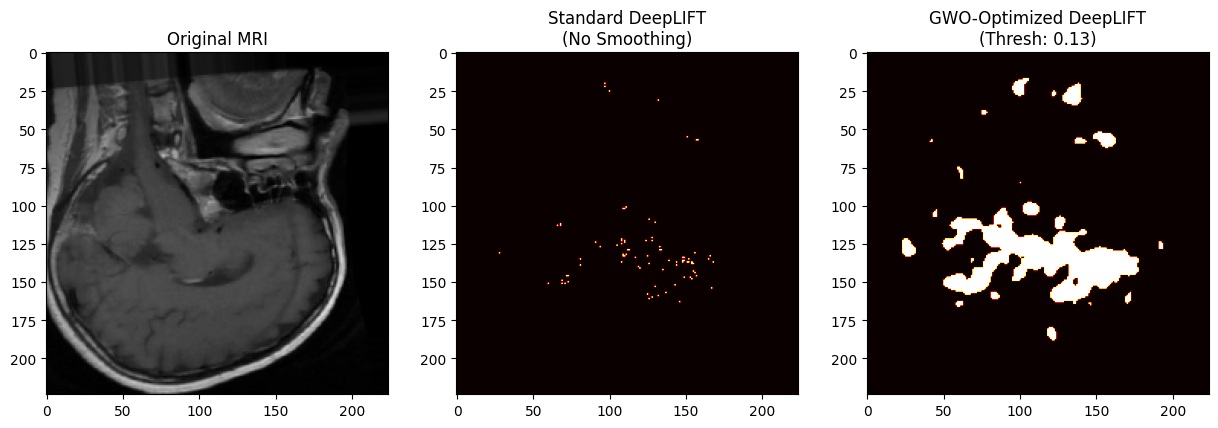

In [23]:
def visualize_deeplift_improvement(model, img, target_class, best_params):
    # Standard: High threshold (0.5), no smoothing
    std_mask = get_deeplift_mask(model, img, target_class, threshold=0.5, sigma=0)
    
    # Optimized: GWO selected threshold and sigma
    opt_mask = get_deeplift_mask(model, img, target_class, best_params[0], best_params[1])
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title("Original MRI")
    
    plt.subplot(1, 3, 2)
    plt.imshow(std_mask, cmap='hot')
    plt.title("Standard DeepLIFT\n(No Smoothing)")
    
    plt.subplot(1, 3, 3)
    plt.imshow(opt_mask, cmap='hot')
    plt.title(f"GWO-Optimized DeepLIFT\n(Thresh: {best_params[0]:.2f})")
    plt.show()

visualize_deeplift_improvement(final_model, test_img, target_idx, best_deep)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


  0%|          | 0/444 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

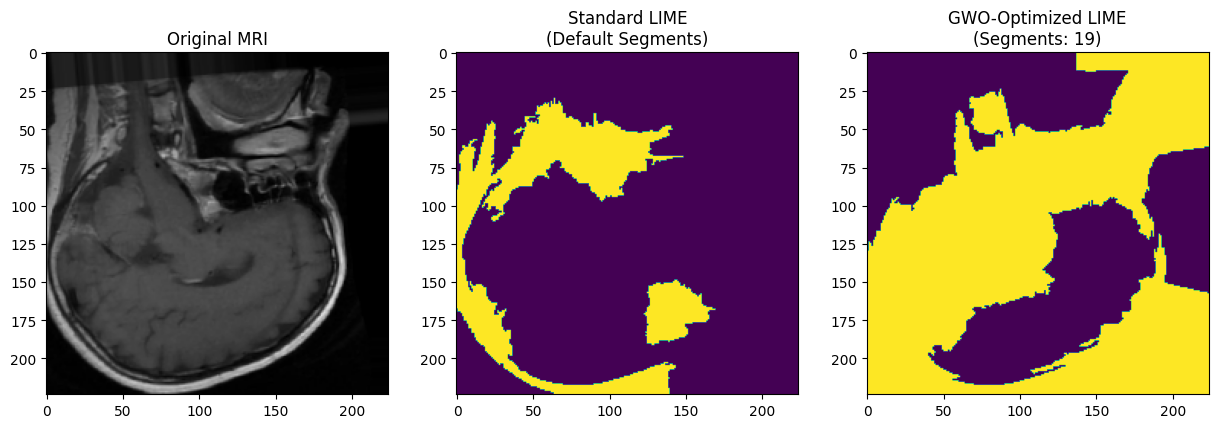

In [24]:
def visualize_lime_improvement(model, img, best_params):
    # Standard: Default segments=50, compactness=10
    std_mask = get_lime_mask(model, img, num_samples=100, compactness=10, n_segments=50)
    
    # Optimized: GWO selected segments and compactness
    opt_mask = get_lime_mask(model, img, best_params[0], best_params[1], best_params[2])
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title("Original MRI")
    
    plt.subplot(1, 3, 2)
    plt.imshow(std_mask, cmap='viridis')
    plt.title("Standard LIME\n(Default Segments)")
    
    plt.subplot(1, 3, 3)
    plt.imshow(opt_mask, cmap='viridis')
    plt.title(f"GWO-Optimized LIME\n(Segments: {int(best_params[2])})")
    plt.show()

visualize_lime_improvement(final_model, test_img, best_lime)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


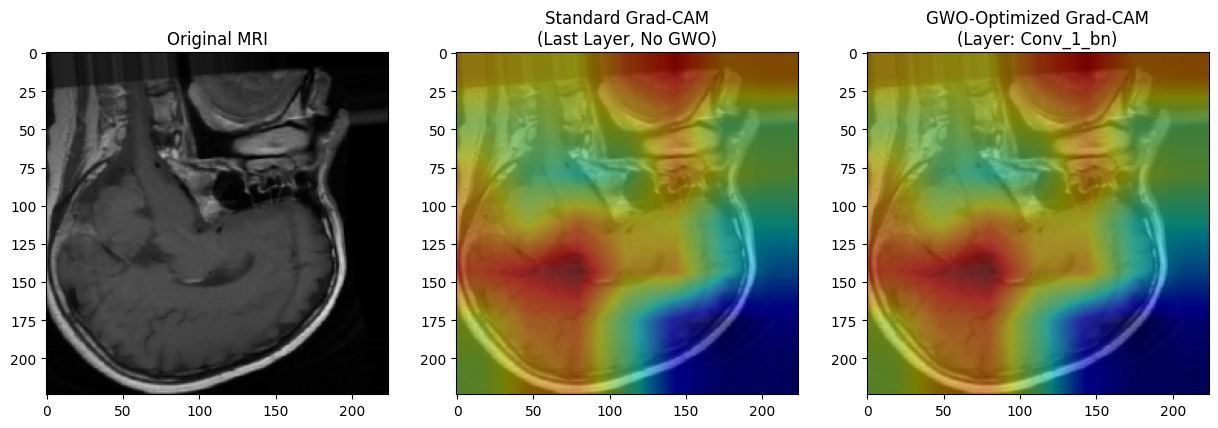

In [25]:
def visualize_gradcam_improvement(model, img, best_params, conv_layers):
    # Standard: Last layer, no smoothing, 0.5 threshold
    std_heatmap, _ = compute_gradcam(model, img, conv_layers[-1], threshold=0.5, sigma=0)
    
    # Optimized: GWO selected parameters
    opt_layer = conv_layers[int(best_params[0])]
    opt_heatmap, _ = compute_gradcam(model, img, opt_layer, best_params[1], best_params[2])
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0].astype('uint8'))
    plt.title("Original MRI")
    
    plt.subplot(1, 3, 2)
    plt.imshow(img[0].astype('uint8'))
    plt.imshow(std_heatmap, cmap='jet', alpha=0.5)
    plt.title("Standard Grad-CAM\n(Last Layer, No GWO)")
    
    plt.subplot(1, 3, 3)
    plt.imshow(img[0].astype('uint8'))
    plt.imshow(opt_heatmap, cmap='jet', alpha=0.5)
    plt.title(f"GWO-Optimized Grad-CAM\n(Layer: {opt_layer})")
    plt.show()

visualize_gradcam_improvement(final_model, test_img, best_grad, grad_layers)